## Country-level INFRA-SAP

- Origins: Population grid (Worldpop downsampled to 500 meters)
- Destinations: Cities, airports, border crossings, and ports

Typical access analysis with two adjustments:
    1. Extract different sets of destinations from OD
    2. Join travel time to origin grid based on "NN with the fastest route" (not necessarily closest NN)

In [1]:
import os, sys, time, importlib

import geopandas as gpd
import pandas as pd
import networkx as nx
sys.path.append('/home/wb514197/Repos/GOSTnets')

import GOSTnets as gn
import GOSTnets.calculate_od_raw as calcOD
from GOSTnets.load_osm import *
import rasterio as rio
from osgeo import gdal
import numpy as np
from shapely.geometry import Point

sys.path.append('/home/wb514197/Repos/INFRA_SAP')
from infrasap import aggregator
from utm_zone import epsg as epsg_get
import json

%load_ext autoreload
%autoreload 2

In [2]:
country = 'mauritania'
iso3 = 'MRT'

### Load origins and graph

In [3]:
# base_in = "/home/public/Data/PROJECTS/INFRA_SAP"
base_in = "/home/wb514197/data/INFRA_SAP"
in_folder = os.path.join(base_in, iso3)

# define data paths
focal_admin2 = os.path.join(in_folder, "admin.shp")
focal_osm = os.path.join(in_folder, f"{country}-latest.osm.pbf")
pop_name = "WP_2020_1km"
wp_1km = os.path.join(in_folder, f"{pop_name}.tif")
urban_extents = os.path.join(in_folder, "urban_extents.shp")
airports = os.path.join(in_folder, "airports.shp")
ports = os.path.join(in_folder, "ports.shp")
borders = os.path.join(in_folder, "borders.shp")

# base_out = "/home/wb514197/data/INFRA_SAP" # GOT permission denied using public 
# out_folder = os.path.join(base_out, iso3)
out_folder = os.path.join(in_folder, "output")

if not os.path.exists(out_folder):
    os.makedirs(out_folder)

In [4]:
bounds = gpd.read_file(focal_admin2)
bounds_json = json.loads(bounds.to_json())
epsg = epsg_get(bounds_json)

Convert **WP_2020_1km.tif** into a point GeoData frame

In [5]:
inDs = gdal.Open(wp_1km)
out_pop = os.path.join(out_folder, f"{pop_name}.xyz")
outDs = gdal.Translate(out_pop, inDs, format='XYZ', creationOptions=["ADD_HEADER_LINE=YES"])
out_pop_csv = os.path.join(out_folder, f"{pop_name}.csv")
os.rename(out_pop, out_pop_csv)

In [6]:
wp_df = pd.read_csv(out_pop_csv, sep=' ')
wp_df.rename(columns={"Z":"Pop"}, inplace=True)
wp_df = wp_df.loc[wp_df.Pop!=-99999.0].copy()
geoms = [Point(xy) for xy in zip(wp_df.X, wp_df.Y)]
wp_df.drop(["X","Y"], axis=1, inplace=True)
crs = 'EPSG:4326'
origins = gpd.GeoDataFrame(wp_df, crs=crs, geometry=geoms)
origins['pointid'] = origins.index

### Prepare Graph

In [7]:
G_path = None # if a graph already exists list the path here
# G_path = os.path.join(in_folder, 'graph', f"G_{iso3}.pickle") 

In [8]:
if G_path is None:
    print("Creating graph from scratch")
    osm_raw = OSM_to_network(focal_osm)
    accepted_road_types = ['trunk','trunk_link','primary','primary_link','secondary','secondary_link','tertiary','tertiary_link']
    osm_raw.filterRoads(acceptedRoads = accepted_road_types)
    osm_raw.generateRoadsGDF(verbose = False)
    osm_raw.initialReadIn()
    
    if not os.path.exists(os.path.join(out_folder, 'graph')):
        os.mkdir(os.path.join(out_folder, 'graph'))
    gn.save(osm_raw.network,f'G_{iso3}_unclean',os.path.join(out_folder, 'graph'))
    
    #clean graph
    G_clean = gn.clean_network(osm_raw.network, UTM = f"EPSG:{epsg}", WGS = "EPSG:4326", junctdist = 50, verbose = False)
    G = G_clean.copy()

else:
    G = nx.read_gpickle(G_path)
    for u, v, data in G.edges(data = True):
        if type(data['Wkt']) == list:
            data['Wkt'] = gn.unbundle_geometry(data['Wkt'])

Creating graph from scratch


/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/wb514197/Repos/GOSTnets/GOSTnets/core.py:1181: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  juncs_gdf_unproj['centroid'] = juncs_gdf_unproj.centroid


1288
2494
404
782
Edge reduction: 2299 to 782 (65 percent)


In [9]:
# Salt network
attr_list = ['id', 'infra_type', 'osm_id', 'key', 'Type']
G_salt = gn.salt_long_lines(G, source='EPSG:4326', target=f'EPSG:{epsg}', thresh=5000, factor=1000, attr_list=attr_list)
G_time = gn.convert_network_to_time(G_salt, distance_tag = 'length', road_col = 'infra_type', factor = 1000)
if not os.path.exists(os.path.join(out_folder, 'graph')):
    os.mkdir(os.path.join(out_folder, 'graph'))
gn.save(G_time, f"G_{iso3}_Salt", os.path.join(out_folder, 'graph'))

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred init

Identified 136 unique edge(s) longer than 5000. 
Beginning new node creation...
3050 new edges added and 274 removed to bring total edges to 3558
1389 new nodes added to bring total nodes to 1701


In [7]:
G_time = nx.read_gpickle(os.path.join(out_folder, 'graph', f'G_{iso3}_Salt.pickle'))

#### Select largest graph

In [8]:
list_of_subgraphs = [G_time.subgraph(c).copy() for c in sorted(nx.strongly_connected_components(G_time), key=len, reverse=True)]
G_largest = list_of_subgraphs[0]

### Prepare destinations

In [9]:
inCities = gpd.read_file(urban_extents)
# pop_thresh = 0
pop_thresh=50000
inCities = inCities.loc[inCities.Pop>pop_thresh]
inCities['geometry'] = inCities.geometry.centroid
dest_cities = inCities.assign(dest_type = 'city')

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """


In [10]:
dest_airports = gpd.read_file(airports)
dest_airports = dest_airports.assign(dest_type = 'airport')

In [11]:
dest_ports = gpd.read_file(ports).assign(dest_type = 'port')
dest_borders = gpd.read_file(borders).assign(dest_type = 'border')
dest_borders['geometry'] = dest_borders.geometry.apply(lambda x: x[0])

In [12]:
dest_all = pd.concat([dest_cities, dest_airports, dest_borders, dest_ports], ignore_index=True)

In [13]:
dest_all.dest_type.value_counts()

airport    4
city       2
border     2
port       2
Name: dest_type, dtype: int64

In [14]:
dest_all.to_csv(os.path.join(out_folder, 'destination_all.csv'))

In [15]:
dest_all.to_file(os.path.join(out_folder, 'destination_all.shp'), driver="ESRI Shapefile")

In [16]:
len(origins), len(dest_all)

(1301390, 10)

### Snap origins and destinations

#### Snap to origins to 5 nearest nodes

In [17]:
utm = f"EPSG:{epsg}"

In [18]:
%%time
# this function returns a dictionary of origin IDs, with a list of 5 NNs, and a corresponding list of distances
origins_snapped_dict = gn.pandana_snap_to_many(G_largest, origins, source_crs='epsg:4326', target_crs=utm, 
                                               add_dist_to_node_col = True, k_nearest=5, origin_id='pointid')

CPU times: user 2min 41s, sys: 2.74 s, total: 2min 44s
Wall time: 2min 44s


In [19]:
dest_snapped = gn.pandana_snap_c(G_largest, dest_all, source_crs='epsg:4326', target_crs=utm,
                                 add_dist_to_node_col = False)

In [20]:
dest_nn = list(dest_snapped['NN'])
list_origins_NN = []
for each in origins_snapped_dict.values():
    list_origins_NN += each['NN']
origins_unique_nn = list(set(list_origins_NN))

In [21]:
%%time
curOD = gn.calculate_OD(G_largest, origins_unique_nn, dest_nn, fail_value = 999999999)

CPU times: user 41.3 ms, sys: 1.02 ms, total: 42.4 ms
Wall time: 41.8 ms


quick checks

In [22]:
curOD[curOD==999999999]

array([], dtype=float64)

In [23]:
curOD.shape

(1322, 10)

In [24]:
od_df = pd.DataFrame(curOD, index=origins_unique_nn, columns=dest_nn)

In [25]:
od_df.head()

,631,new_obj_364,1646,new_obj_468,new_obj_378,151_19_167,387,387,new_obj_470,new_obj_372
1786_130_1105,55313.608008,12295.387979,26972.101955,55133.978919,12108.182517,31425.701021,30592.576969,30592.576969,54913.006722,12361.982663
1786_126_1101,53513.698008,10495.477979,28772.011955,53334.068919,10308.272517,33225.611021,28792.666969,28792.666969,53113.096722,10562.072663
new_obj_247_136_1392,67088.154442,23885.839717,63033.989812,66908.525354,24073.045179,67487.588877,21491.618529,21491.618529,66687.553157,24136.529097
232_18_214,58120.769333,15024.866314,54292.356249,57941.140244,15212.071777,58745.955314,3272.322676,3272.322676,57720.168047,15275.555695
18,107733.696934,64531.382209,100058.342809,107554.067846,64718.587671,104511.941875,64016.361021,64016.361021,107333.095649,64782.071589


For each origin set of 5 (k) possible NN:
    - Add snapping dist (in time) + time to a destination
    - Which destination? min time from all of them won't necessarily work, so we need to find the closest destination for each origin, and select the NN which yields the fastest travel time to that dest
    - closest_dest.idx should match the OD column order.

In [26]:
%%time
closest_dest = gn.pandana_snap_points(origins, dest_all, source_crs='epsg:4326', target_crs=utm,
                                      add_dist_to_node_col=True)

CPU times: user 1min 5s, sys: 977 ms, total: 1min 6s
Wall time: 1min 6s


In [27]:
closest_dest = closest_dest.set_index('pointid')

In [28]:
closest_dest.head()

,Pop,geometry,idx,idx_dist
pointid,,,,
1007,0.048485,POINT (1127094.521 3034897.174),5,857837.832349
1008,0.042619,POINT (1127922.097 3034939.298),5,858254.231858
1009,0.038052,POINT (1128749.680 3034981.479),5,858671.282668
2475,0.051130,POINT (1127141.634 3033970.854),5,857035.837519
2476,0.039548,POINT (1127969.272 3034012.969),5,857452.647651


In [29]:
%%time
fastest_nn = []
fastest_dist = []
custom_speed = 30 # km/h

for pointid, items in origins_snapped_dict.items():
    dest_index = closest_dest.loc[pointid].idx
    nn_list = items['NN']
    dist_list = items['NN_dist']
    total_time_list = []
    for i in range(0, len(nn_list)):
        time_snapping = ((dist_list[i] / 1000) / custom_speed) * 60 * 60
        #time_to_dest = od_df.loc[nn_list[i]].min()
        time_to_dest = od_df.loc[nn_list[i]].iloc[dest_index]
        total_time = time_snapping+time_to_dest
        total_time_list.append(total_time)
#         print(f"id: {nn_list[i]}, snapping dist (km): {dist_list[i]/1000:.2f}, time to dest (min): {(total_time/60)/60:.2f}")
    min_pos = total_time_list.index(min(total_time_list))
    fastest_nn.append(nn_list[min_pos])
    fastest_dist.append(dist_list[min_pos])
#     origins_snapped_smart.loc[pointid, "NN"] = nn_list[min_pos]
#     origins_snapped_smart.loc[pointid, "NN_dist"] = dist_list[min_pos]

CPU times: user 14min 34s, sys: 650 ms, total: 14min 35s
Wall time: 14min 35s


In [30]:
origins_snapped = origins.copy().set_index('pointid')
origins_snapped['NN'] = pd.Series(fastest_nn, index = origins_snapped.index)
origins_snapped['NN_dist'] = pd.Series(fastest_dist, index = origins_snapped.index)
origins_snapped['pointid'] = origins_snapped.index
origins_snapped['NN_dist_seconds'] = ((origins_snapped.NN_dist / 1000) / custom_speed) * 60 * 60
origins_snapped['NN_dist_hours'] = ((origins_snapped.NN_dist / 1000) / custom_speed)

In [31]:
origins_snapped.head()

,Pop,geometry,NN,NN_dist,pointid,NN_dist_seconds,NN_dist_hours
pointid,,,,,,,
1007,0.048485,POINT (-8.67042 27.29375),1867_120_1261,598004.050616,1007,71760.486074,19.933468
1008,0.042619,POINT (-8.66208 27.29375),1867_120_1261,598502.714029,1008,71820.325683,19.950090
1009,0.038052,POINT (-8.65375 27.29375),1867_120_1261,599002.159554,1009,71880.259146,19.966739
2475,0.051130,POINT (-8.67042 27.28542),1867_120_1261,597263.206675,2475,71671.584801,19.908774
2476,0.039548,POINT (-8.66208 27.28542),1867_120_1261,597762.516262,2476,71731.501951,19.925417


In [32]:
origins_join = origins_snapped.join(od_df, on='NN')

In [33]:
all(origins_join.columns[7:] == dest_snapped.NN)

True

In [34]:
origins_join_rename = origins_join.copy()
origins_join_rename.columns = pd.MultiIndex.from_arrays([['origin' for each in origins_snapped.columns]+list(dest_snapped.dest_type), origins_snapped.columns.append(dest_snapped.index)])

In [35]:
origins_join_rename.head()

origin                                                           \
              Pop                   geometry             NN        NN_dist   
pointid                                                                      
1007     0.048485  POINT (-8.67042 27.29375)  1867_120_1261  598004.050616   
1008     0.042619  POINT (-8.66208 27.29375)  1867_120_1261  598502.714029   
1009     0.038052  POINT (-8.65375 27.29375)  1867_120_1261  599002.159554   
2475     0.051130  POINT (-8.67042 27.28542)  1867_120_1261  597263.206675   
2476     0.039548  POINT (-8.66208 27.28542)  1867_120_1261  597762.516262   

                                                        city                \
        pointid NN_dist_seconds NN_dist_hours              0             1   
pointid                                                                      
1007       1007    71760.486074     19.933468  113430.449201  70412.229172   
1008       1008    71820.325683     19.950090  113430.449201  70412.229172   
1009       1009    71880.259146     19.966739  113430.449201  70412.229172   
2475       2475    71671.584801     19.908774  113430.449201  70412.229172   
2476       2476    71731.501951     19.925417  113430.449201  70412.229172   

              airport                                                  border  \
                    2              3            4             5             6   
pointid                                                                         
1007     31313.788167  113250.820112  70225.02371  35090.180172  88709.418162   
1008     31313.788167  113250.820112  70225.02371  35090.180172  88709.418162   
1009     31313.788167  113250.820112  70225.02371  35090.180172  88709.418162   
2475     31313.788167  113250.820112  70225.02371  35090.180172  88709.418162   
2476     31313.788167  113250.820112  70225.02371  35090.180172  88709.418162   

                                port                
                    7              8             9  
pointid                                             
1007     88709.418162  113029.847915  70478.823856  
1008     88709.418162  113029.847915  70478.823856  
1009     88709.418162  113029.847915  70478.823856  
2475     88709.418162  113029.847915  70478.823856  
2476     88709.418162  113029.847915  70478.823856

Add snapping time to each column (speed of 30 km/h)

In [36]:
origins_join2 = origins_join_rename.apply(lambda x: x + origins_join_rename.origin.NN_dist_seconds if x.name[1] in dest_snapped.index else x)

In [37]:
origins_join2.head()

origin                                                           \
              Pop                   geometry             NN        NN_dist   
pointid                                                                      
1007     0.048485  POINT (-8.67042 27.29375)  1867_120_1261  598004.050616   
1008     0.042619  POINT (-8.66208 27.29375)  1867_120_1261  598502.714029   
1009     0.038052  POINT (-8.65375 27.29375)  1867_120_1261  599002.159554   
2475     0.051130  POINT (-8.67042 27.28542)  1867_120_1261  597263.206675   
2476     0.039548  POINT (-8.66208 27.28542)  1867_120_1261  597762.516262   

                                                        city                 \
        pointid NN_dist_seconds NN_dist_hours              0              1   
pointid                                                                       
1007       1007    71760.486074     19.933468  185190.935275  142172.715246   
1008       1008    71820.325683     19.950090  185250.774884  142232.554856   
1009       1009    71880.259146     19.966739  185310.708347  142292.488319   
2475       2475    71671.584801     19.908774  185102.034002  142083.813973   
2476       2476    71731.501951     19.925417  185161.951152  142143.731124   

               airport                                               \
                     2              3              4              5   
pointid                                                               
1007     103074.274241  185011.306186  141985.509784  106850.666246   
1008     103134.113851  185071.145796  142045.349393  106910.505856   
1009     103194.047314  185131.079259  142105.282856  106970.439319   
2475     102985.372968  184922.404913  141896.608511  106761.764973   
2476     103045.290119  184982.322064  141956.525661  106821.682124   

                border                          port                 
                     6              7              8              9  
pointid                                                              
1007     160469.904236  160469.904236  184790.333989  142239.309930  
1008     160529.743846  160529.743846  184850.173599  142299.149539  
1009     160589.677309  160589.677309  184910.107062  142359.083002  
2475     160381.002963  160381.002963  184701.432716  142150.408657  
2476     160440.920114  160440.920114  184761.349867  142210.325807

In [38]:
origins_join2.to_csv(os.path.join(out_folder, 'OD_03_04.csv'))

In [39]:
od_cities = np.array(origins_join2['city'])

### Calculate gravity

In [40]:
%%time
access_cities = calcOD.calculate_gravity(od_cities, dWeight = dest_all.Pop[origins_join2['city'].columns])

CPU times: user 33min 34s, sys: 5.92 s, total: 33min 40s
Wall time: 33min 38s


In [41]:
access_cities.index = origins_join2.index

In [42]:
access_cities_results = origins_snapped.join(access_cities).rename(columns = {
        'd_0.01': 'd_1',
        'd_0.005': 'd_2',
        'd_0.001' : 'd_3',
        'd_0.0007701635' : 'd_4',   # Market access halves every 15 mins
        'd_0.0003850818' : 'd_5',   # Market access halves every 30 mins
        'd_0.0001925409' : 'd_6',   # Market access halves every 60 mins
        'd_9.62704e-05' : 'd_7',   # Market access halves every 120 mins
        'd_3.85082e-05' : 'd_8',   # Market access halves every 300 mins
        'd_1e-05' : 'd_9'
    })

#### Convert to raster and save results

In [43]:
raster_path = wp_1km

In [44]:
output_path = os.path.join(out_folder, "access")
if not os.path.exists(output_path):
    os.mkdir(output_path)

<AxesSubplot:>

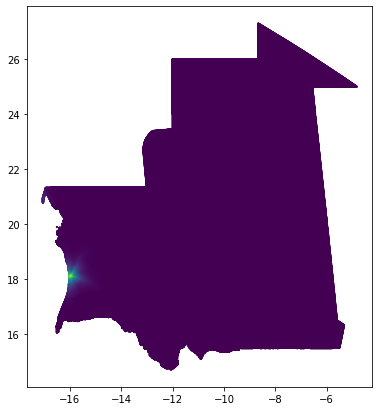

In [45]:
access_cities_results.plot(column='d_5', figsize=(7,7), markersize=1)

In [ ]:
for d in range(5,10):
    print(f'writing {d}')
    aggregator.rasterize_gdf(access_cities_results, f'd_{d}', template=raster_path, outFile=os.path.join(output_path,f"access_cities_d{d}.tif"))

writing 5
writing 6
writing 7
writing 8


### Make rasters of min travel time to each dest

In [59]:
out_folder

'/home/wb514197/data/INFRA_SAP/MRT/output'

In [60]:
output_path = os.path.join(out_folder, "travel_time")
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [61]:
# CHECK THAT MOST POPULATED CITY IS THE CAPITAL
cap_idx = dest_all.sort_values('Pop', ascending=False).iloc[[0]].index[0]

In [62]:
city_min = pd.DataFrame(origins_join2['city'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_city"])
ports_min = pd.DataFrame(origins_join2['port'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_port"])
airports_min = pd.DataFrame(origins_join2['airport'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_airport"])
borders_min = pd.DataFrame(origins_join2['border'].min(axis=1).apply(lambda x: (x/3600)), columns=["tt_border"])
capital_tt = origins_join2['city'].loc[:,[cap_idx]].apply(lambda x: (x/3600)).rename(columns={cap_idx:'tt_capital'})

In [66]:
origins_tt = origins_snapped.join([city_min, airports_min, borders_min, capital_tt, ports_min])

In [67]:
output_path

'/home/wb514197/data/INFRA_SAP/MRT/output/travel_time'

In [68]:
aggregator.rasterize_gdf(origins_tt, 'tt_city', raster_path, os.path.join(output_path,f"cities_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_port', raster_path, os.path.join(output_path,f"port_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_airport', raster_path, os.path.join(output_path,f"airport_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_border', raster_path, os.path.join(output_path,f"borders_min_tt.tif"))
aggregator.rasterize_gdf(origins_tt, 'tt_capital', raster_path, os.path.join(output_path,f"capital_tt.tif"))